# **Model Implementation**

EfficientNet-B0

In [ ]:
from datasets import load_dataset
from huggingface_hub import login
import os
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import gc

print("Streaming dataset...")
ds_stream = load_dataset("saberzl/SID_Set", split="train", streaming=True)

# Step 3: Setup directories for 3 classes
save_dir = "/content/sid_images"
os.makedirs(f"{save_dir}/real", exist_ok=True)
os.makedirs(f"{save_dir}/synthetic", exist_ok=True)
os.makedirs(f"{save_dir}/tampered", exist_ok=True)

target_per_class = 3600
class_counts = {'real': 0, 'synthetic': 0, 'tampered': 0}

print(f"Downloading {target_per_class} images per class (Real, Synthetic, Tampered)...")
print("Saving images directly to disk to avoid memory issues\n")

pbar = tqdm(ds_stream)
for sample in pbar:
    # Get label (0=Real, 1=Synthetic, 2=Tampered)
    label = sample.get('label', sample.get('class', None))

    if label is None:
        print(f"Available keys: {sample.keys()}")
        break

    # Map label to class name
    if label == 0:
        class_name = 'real'
    elif label == 1:
        class_name = 'synthetic'
    elif label == 2:
        class_name = 'tampered'
    else:
        continue

    if class_counts[class_name] >= target_per_class:
        if all(count >= target_per_class for count in class_counts.values()):
            print("\n Downloaded target number for all classes!")
            break
        continue

    if 'image' in sample:
        img = sample['image']
        if isinstance(img, Image.Image):
            class_counts[class_name] += 1
            img_filename = f"{class_name}_{class_counts[class_name]:05d}.png"
            img_path = f"{save_dir}/{class_name}/{img_filename}"

            # Convert all images to RGB (handles RGBA, CMYK, L, etc.)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Save as PNG
            img.save(img_path, 'PNG')
            img.close()

            # Update progress bar
            pbar.set_description(
                f"Real: {class_counts['real']}/{target_per_class} | "
                f"Synth: {class_counts['synthetic']}/{target_per_class} | "
                f"Tamp: {class_counts['tampered']}/{target_per_class}"
            )

            # Force garbage collection every 100 images
            if sum(class_counts.values()) % 100 == 0:
                gc.collect()

pbar.close()

print(f"\n{'='*70}")
print(f"Download Complete!")
print(f"{'='*70}")
print(f"Real images:      {class_counts['real']}")
print(f"Synthetic images: {class_counts['synthetic']}")
print(f"Tampered images:  {class_counts['tampered']}")
print(f"Total images:     {sum(class_counts.values())}")
print(f"Images saved to:  {save_dir}")
print(f"{'='*70}")

# Step 4: Create PyTorch Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

class SIDDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Load real images (label 0)
        real_dir = os.path.join(root_dir, 'real')
        if os.path.exists(real_dir):
            for img_name in sorted(os.listdir(real_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(real_dir, img_name), 0))

        # Load synthetic images (label 1)
        synth_dir = os.path.join(root_dir, 'synthetic')
        if os.path.exists(synth_dir):
            for img_name in sorted(os.listdir(synth_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(synth_dir, img_name), 1))

        # Load tampered images (label 2)
        tamp_dir = os.path.join(root_dir, 'tampered')
        if os.path.exists(tamp_dir):
            for img_name in sorted(os.listdir(tamp_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(tamp_dir, img_name), 2))

        print(f"\nDataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label



In [ ]:
!pip install torch torchvision tqdm pillow -q

# Importing librarires

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

#Configuration

In [ ]:


class Config:
    # Paths
    data_dir = '/content/sid_images'
    save_dir = './checkpoints'

    # Model
    backbone = 'efficientnet_b0'
    pretrained = True
    num_classes = 3

    # Training
    epochs = 20
    batch_size = 32
    lr = 1e-4
    weight_decay = 1e-4
    num_workers = 2


    save_freq = 5
    seed = 42

config = Config()

#random seed for reproducibility
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# Create save directory
os.makedirs(config.save_dir, exist_ok=True)

print("Configuration loaded!")
print(f"Data directory: {config.data_dir}")
print(f"Save directory: {config.save_dir}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")



#Dataset Class

In [ ]:
class SIDDataset(Dataset):

    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.samples = []

        # Load real images
        real_dir = os.path.join(root_dir, 'real')
        if os.path.exists(real_dir):
            for img_name in sorted(os.listdir(real_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(real_dir, img_name), 0))

        # Load synthetic images
        synth_dir = os.path.join(root_dir, 'synthetic')
        if os.path.exists(synth_dir):
            for img_name in sorted(os.listdir(synth_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(synth_dir, img_name), 1))

        # Load tampered images
        tamp_dir = os.path.join(root_dir, 'tampered')
        if os.path.exists(tamp_dir):
            for img_name in sorted(os.listdir(tamp_dir)):
                if img_name.endswith('.png'):
                    self.samples.append((os.path.join(tamp_dir, img_name), 2))

        # Split into train/val
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))
        split_idx = int(0.8 * len(self.samples))

        if split == 'train':
            indices = indices[:split_idx]
        else:
            indices = indices[split_idx:]

        self.samples = [self.samples[i] for i in indices]

        print(f"\n{split.capitalize()} Dataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

print("Dataset class defined!")

#Model Definition

In [ ]:
class SimpleSIDA(nn.Module):
    def __init__(self, num_classes=3, backbone='efficientnet_b0', pretrained=True):
        super(SimpleSIDA, self).__init__()
        from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

        if pretrained:
            self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        else:
            self.backbone = efficientnet_b0(weights=None)

        self.feature_dim = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()  # remove original classifier

        self.cls_head = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.cls_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        logits = self.cls_head(features)
        return logits


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Train]")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

print("Training function defined!")

In [ ]:
def validate(model, dataloader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    num_classes = 3
    confusion_matrix = torch.zeros(num_classes, num_classes)

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} [Val]")
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for t, p in zip(labels.cpu(), predicted.cpu()):
                confusion_matrix[t.long(), p.long()] += 1

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    class_names = ['Real', 'Synthetic', 'Tampered']
    per_class_metrics = {}

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp

        total_class = confusion_matrix[i, :].sum()
        class_acc = float(tp / total_class) if total_class > 0 else 0.0
        precision = float(tp / (tp + fp)) if (tp + fp) > 0 else 0.0
        recall = float(tp / (tp + fn)) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        per_class_metrics[class_names[i]] = {
            'accuracy': class_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    print(f"\n{'='*60}")
    print(f"Validation Results (Epoch {epoch+1}):")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"Average Loss: {avg_loss:.4f}")
    print("\nPer-Class Metrics:")
    for class_name, metrics in per_class_metrics.items():
        print(f"\n{class_name}:")
        print(f"  Accuracy:  {metrics['accuracy']*100:.2f}%")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1:        {metrics['f1']:.4f}")

    print("\nConfusion Matrix:")
    print(f"{'':12}", end="")
    for name in class_names:
        print(f"{name:>12}", end="")
    print()
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<12}", end="")
        for j in range(num_classes):
            print(f"{int(confusion_matrix[i, j]):>12}", end="")
        print()
    print(f"{'='*60}\n")

    return avg_loss, accuracy, per_class_metrics, confusion_matrix

print("Validation function defined!")



In [ ]:
def plot_training_history(results, save_path):
    """Plot training history"""
    epochs = [r['epoch'] for r in results]
    train_losses = [r['train_loss'] for r in results]
    val_losses = [r['val_loss'] for r in results]
    train_accs = [r['train_acc'] for r in results]
    val_accs = [r['val_acc'] for r in results]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_losses, label='Train Loss', marker='o')
    ax1.plot(epochs, val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(epochs, train_accs, label='Train Acc', marker='o')
    ax2.plot(epochs, val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Training history saved to {save_path}")

def plot_confusion_matrix(cm, save_path):
    """Plot confusion matrix"""
    class_names = ['Real', 'Synthetic', 'Tampered']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm.numpy(), annot=True, fmt='.0f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Final Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Confusion matrix saved to {save_path}")

print("Visualization functions defined!")



#Creating Datasets and Dataloaders

In [ ]:
class SIDDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.samples = []

        # Load images by class
        class_dirs = {'real': 0, 'synthetic': 1, 'tampered': 2}
        for cls_name, cls_label in class_dirs.items():
            cls_dir = os.path.join(root_dir, cls_name)
            if os.path.exists(cls_dir):
                for img_name in sorted(os.listdir(cls_dir)):
                    if img_name.endswith('.png'):
                        self.samples.append((os.path.join(cls_dir, img_name), cls_label))

        # Shuffle indices
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))

        # Split 70% train, 15% val, 15% test
        n = len(self.samples)
        train_idx = int(0.7 * n)
        val_idx = int(0.85 * n)

        if split == 'train':
            indices = indices[:train_idx]
        elif split == 'val':
            indices = indices[train_idx:val_idx]
        else:  # test
            indices = indices[val_idx:]

        self.samples = [self.samples[i] for i in indices]

        print(f"\n{split.capitalize()} Dataset Statistics:")
        print(f"  Real: {sum(1 for _, l in self.samples if l == 0)}")
        print(f"  Synthetic: {sum(1 for _, l in self.samples if l == 1)}")
        print(f"  Tampered: {sum(1 for _, l in self.samples if l == 2)}")
        print(f"  Total: {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Transforms
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Datasets
train_dataset = SIDDataset(config.data_dir, transform=train_transform, split='train')
val_dataset = SIDDataset(config.data_dir, transform=val_test_transform, split='val')
test_dataset = SIDDataset(config.data_dir, transform=val_test_transform, split='test')

# Dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


#Initialize Model, Loss, Optimizer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Create model
print("Creating model...")
model = SimpleSIDA(num_classes=config.num_classes,
                   backbone=config.backbone,
                   pretrained=config.pretrained)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=config.epochs)

print("\nModel, loss, and optimizer initialized!")

# **Model Training**

In [13]:
print(f"\n{'='*70}")
print(f"Starting Training")
print(f"{'='*70}")
print(f"Total epochs: {config.epochs}")
print(f"Batch size: {config.batch_size}")
print(f"Learning rate: {config.lr}")
print(f"{'='*70}\n")

best_acc = 0.0
results = []

for epoch in range(config.epochs):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )

    # Validate
    val_loss, val_acc, per_class_metrics, cm = validate(
        model, val_loader, criterion, device, epoch
    )

    scheduler.step()

    # Save results
    results.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'per_class_metrics': per_class_metrics
    })

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, os.path.join(config.save_dir, 'best_model.pth'))
        print(f"✓ New best model saved! Accuracy: {val_acc:.2f}%\n")

    # Save periodic checkpoint
    if (epoch + 1) % config.save_freq == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, os.path.join(config.save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

# Save final model
torch.save({
    'epoch': config.epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'results': results,
}, os.path.join(config.save_dir, 'final_model.pth'))

# Save results as JSON
with open(os.path.join(config.save_dir, 'training_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n{'='*70}")
print(f"Training Completed!")
print(f"Best Validation Accuracy: {best_acc:.2f}%")
print(f"Models saved to: {config.save_dir}")
print(f"{'='*70}\n")



Starting Training
Total epochs: 20
Batch size: 32
Learning rate: 0.0001



Epoch 1 [Val]: 100%|██████████| 51/51 [00:52<00:00,  1.03s/it, loss=0.3425, acc=82.23%]



Validation Results (Epoch 1):
Overall Accuracy: 82.23%
Average Loss: 0.3918

Per-Class Metrics:

Real:
  Accuracy:  74.33%
  Precision: 0.7307
  Recall:    0.7433
  F1:        0.7369

Synthetic:
  Accuracy:  98.47%
  Precision: 0.9717
  Recall:    0.9847
  F1:        0.9782

Tampered:
  Accuracy:  74.65%
  Precision: 0.7679
  Recall:    0.7465
  F1:        0.7570

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 388           7         127
Synthetic              5         515           3
Tampered             138           8         430

✓ New best model saved! Accuracy: 82.23%



Epoch 2 [Val]: 100%|██████████| 51/51 [00:52<00:00,  1.03s/it, loss=0.2747, acc=83.04%]



Validation Results (Epoch 2):
Overall Accuracy: 83.04%
Average Loss: 0.3712

Per-Class Metrics:

Real:
  Accuracy:  83.72%
  Precision: 0.7117
  Recall:    0.8372
  F1:        0.7694

Synthetic:
  Accuracy:  99.04%
  Precision: 0.9682
  Recall:    0.9904
  F1:        0.9792

Tampered:
  Accuracy:  67.88%
  Precision: 0.8284
  Recall:    0.6788
  F1:        0.7462

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 437           7          78
Synthetic              2         518           3
Tampered             175          10         391

✓ New best model saved! Accuracy: 83.04%



Epoch 3 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.04s/it, loss=0.2976, acc=84.15%]



Validation Results (Epoch 3):
Overall Accuracy: 84.15%
Average Loss: 0.3638

Per-Class Metrics:

Real:
  Accuracy:  84.29%
  Precision: 0.7237
  Recall:    0.8429
  F1:        0.7788

Synthetic:
  Accuracy:  99.24%
  Precision: 0.9811
  Recall:    0.9924
  F1:        0.9867

Tampered:
  Accuracy:  70.31%
  Precision: 0.8368
  Recall:    0.7031
  F1:        0.7642

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 440           4          78
Synthetic              3         519           1
Tampered             165           6         405

✓ New best model saved! Accuracy: 84.15%



Epoch 4 [Val]: 100%|██████████| 51/51 [00:52<00:00,  1.03s/it, loss=0.2702, acc=85.01%]



Validation Results (Epoch 4):
Overall Accuracy: 85.01%
Average Loss: 0.3560

Per-Class Metrics:

Real:
  Accuracy:  81.03%
  Precision: 0.7567
  Recall:    0.8103
  F1:        0.7826

Synthetic:
  Accuracy:  99.43%
  Precision: 0.9793
  Recall:    0.9943
  F1:        0.9867

Tampered:
  Accuracy:  75.52%
  Precision: 0.8192
  Recall:    0.7552
  F1:        0.7859

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 423           5          94
Synthetic              1         520           2
Tampered             135           6         435

✓ New best model saved! Accuracy: 85.01%



Epoch 5 [Val]: 100%|██████████| 51/51 [00:52<00:00,  1.04s/it, loss=0.3246, acc=85.38%]



Validation Results (Epoch 5):
Overall Accuracy: 85.38%
Average Loss: 0.4240

Per-Class Metrics:

Real:
  Accuracy:  84.67%
  Precision: 0.7492
  Recall:    0.8467
  F1:        0.7950

Synthetic:
  Accuracy:  99.04%
  Precision: 0.9755
  Recall:    0.9904
  F1:        0.9829

Tampered:
  Accuracy:  73.61%
  Precision: 0.8480
  Recall:    0.7361
  F1:        0.7881

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 442           7          73
Synthetic              2         518           3
Tampered             146           6         424

✓ New best model saved! Accuracy: 85.38%



Epoch 6 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.04s/it, loss=0.3136, acc=84.95%]



Validation Results (Epoch 6):
Overall Accuracy: 84.95%
Average Loss: 0.4269

Per-Class Metrics:

Real:
  Accuracy:  82.95%
  Precision: 0.7504
  Recall:    0.8295
  F1:        0.7880

Synthetic:
  Accuracy:  98.28%
  Precision: 0.9847
  Recall:    0.9828
  F1:        0.9837

Tampered:
  Accuracy:  74.65%
  Precision: 0.8238
  Recall:    0.7465
  F1:        0.7832

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 433           3          86
Synthetic              3         514           6
Tampered             141           5         430



Epoch 7 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.04s/it, loss=0.5648, acc=85.01%]



Validation Results (Epoch 7):
Overall Accuracy: 85.01%
Average Loss: 0.4826

Per-Class Metrics:

Real:
  Accuracy:  82.57%
  Precision: 0.7509
  Recall:    0.8257
  F1:        0.7865

Synthetic:
  Accuracy:  98.85%
  Precision: 0.9792
  Recall:    0.9885
  F1:        0.9838

Tampered:
  Accuracy:  74.65%
  Precision: 0.8285
  Recall:    0.7465
  F1:        0.7854

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 431           5          86
Synthetic              3         517           3
Tampered             140           6         430



Epoch 8 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.06s/it, loss=0.3039, acc=84.64%]



Validation Results (Epoch 8):
Overall Accuracy: 84.64%
Average Loss: 0.5033

Per-Class Metrics:

Real:
  Accuracy:  81.80%
  Precision: 0.7452
  Recall:    0.8180
  F1:        0.7799

Synthetic:
  Accuracy:  98.66%
  Precision: 0.9847
  Recall:    0.9866
  F1:        0.9857

Tampered:
  Accuracy:  74.48%
  Precision: 0.8187
  Recall:    0.7448
  F1:        0.7800

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 427           2          93
Synthetic              5         516           2
Tampered             141           6         429



Epoch 9 [Val]: 100%|██████████| 51/51 [00:52<00:00,  1.03s/it, loss=0.3824, acc=85.26%]



Validation Results (Epoch 9):
Overall Accuracy: 85.26%
Average Loss: 0.5067

Per-Class Metrics:

Real:
  Accuracy:  83.72%
  Precision: 0.7470
  Recall:    0.8372
  F1:        0.7895

Synthetic:
  Accuracy:  99.43%
  Precision: 0.9793
  Recall:    0.9943
  F1:        0.9867

Tampered:
  Accuracy:  73.78%
  Precision: 0.8416
  Recall:    0.7378
  F1:        0.7863

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 437           5          80
Synthetic              3         520           0
Tampered             145           6         425



Epoch 10 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.04s/it, loss=0.3963, acc=84.64%]



Validation Results (Epoch 10):
Overall Accuracy: 84.64%
Average Loss: 0.5405

Per-Class Metrics:

Real:
  Accuracy:  83.91%
  Precision: 0.7374
  Recall:    0.8391
  F1:        0.7849

Synthetic:
  Accuracy:  99.43%
  Precision: 0.9683
  Recall:    0.9943
  F1:        0.9811

Tampered:
  Accuracy:  71.88%
  Precision: 0.8449
  Recall:    0.7188
  F1:        0.7767

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 438           8          76
Synthetic              3         520           0
Tampered             153           9         414



Epoch 11 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.05s/it, loss=0.4658, acc=85.75%]



Validation Results (Epoch 11):
Overall Accuracy: 85.75%
Average Loss: 0.5481

Per-Class Metrics:

Real:
  Accuracy:  80.46%
  Precision: 0.7763
  Recall:    0.8046
  F1:        0.7902

Synthetic:
  Accuracy:  99.24%
  Precision: 0.9811
  Recall:    0.9924
  F1:        0.9867

Tampered:
  Accuracy:  78.30%
  Precision: 0.8185
  Recall:    0.7830
  F1:        0.8004

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 420           3          99
Synthetic              3         519           1
Tampered             118           7         451

✓ New best model saved! Accuracy: 85.75%



Epoch 12 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.04s/it, loss=0.4294, acc=86.00%]



Validation Results (Epoch 12):
Overall Accuracy: 86.00%
Average Loss: 0.5460

Per-Class Metrics:

Real:
  Accuracy:  79.50%
  Precision: 0.7845
  Recall:    0.7950
  F1:        0.7897

Synthetic:
  Accuracy:  99.24%
  Precision: 0.9848
  Recall:    0.9924
  F1:        0.9886

Tampered:
  Accuracy:  79.86%
  Precision: 0.8142
  Recall:    0.7986
  F1:        0.8063

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 415           2         105
Synthetic              4         519           0
Tampered             110           6         460

✓ New best model saved! Accuracy: 86.00%



Epoch 13 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.05s/it, loss=0.3506, acc=86.30%]



Validation Results (Epoch 13):
Overall Accuracy: 86.30%
Average Loss: 0.5723

Per-Class Metrics:

Real:
  Accuracy:  84.29%
  Precision: 0.7666
  Recall:    0.8429
  F1:        0.8029

Synthetic:
  Accuracy:  99.43%
  Precision: 0.9811
  Recall:    0.9943
  F1:        0.9877

Tampered:
  Accuracy:  76.22%
  Precision: 0.8491
  Recall:    0.7622
  F1:        0.8033

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 440           4          78
Synthetic              3         520           0
Tampered             131           6         439

✓ New best model saved! Accuracy: 86.30%



Epoch 14 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.04s/it, loss=0.4842, acc=84.76%]



Validation Results (Epoch 14):
Overall Accuracy: 84.76%
Average Loss: 0.6305

Per-Class Metrics:

Real:
  Accuracy:  85.82%
  Precision: 0.7296
  Recall:    0.8582
  F1:        0.7887

Synthetic:
  Accuracy:  99.24%
  Precision: 0.9792
  Recall:    0.9924
  F1:        0.9858

Tampered:
  Accuracy:  70.66%
  Precision: 0.8532
  Recall:    0.7066
  F1:        0.7730

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 448           4          70
Synthetic              4         519           0
Tampered             162           7         407



Epoch 15 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.05s/it, loss=0.4159, acc=85.56%]



Validation Results (Epoch 15):
Overall Accuracy: 85.56%
Average Loss: 0.5861

Per-Class Metrics:

Real:
  Accuracy:  83.91%
  Precision: 0.7526
  Recall:    0.8391
  F1:        0.7935

Synthetic:
  Accuracy:  99.04%
  Precision: 0.9848
  Recall:    0.9904
  F1:        0.9876

Tampered:
  Accuracy:  74.83%
  Precision: 0.8402
  Recall:    0.7483
  F1:        0.7916

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 438           2          82
Synthetic              5         518           0
Tampered             139           6         431



Epoch 16 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.04s/it, loss=0.5104, acc=86.30%]



Validation Results (Epoch 16):
Overall Accuracy: 86.30%
Average Loss: 0.6036

Per-Class Metrics:

Real:
  Accuracy:  83.91%
  Precision: 0.7739
  Recall:    0.8391
  F1:        0.8051

Synthetic:
  Accuracy:  99.43%
  Precision: 0.9701
  Recall:    0.9943
  F1:        0.9821

Tampered:
  Accuracy:  76.56%
  Precision: 0.8497
  Recall:    0.7656
  F1:        0.8055

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 438           6          78
Synthetic              3         520           0
Tampered             125          10         441



Epoch 17 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.04s/it, loss=0.4752, acc=85.44%]



Validation Results (Epoch 17):
Overall Accuracy: 85.44%
Average Loss: 0.6151

Per-Class Metrics:

Real:
  Accuracy:  83.52%
  Precision: 0.7543
  Recall:    0.8352
  F1:        0.7927

Synthetic:
  Accuracy:  98.85%
  Precision: 0.9810
  Recall:    0.9885
  F1:        0.9848

Tampered:
  Accuracy:  75.00%
  Precision: 0.8372
  Recall:    0.7500
  F1:        0.7912

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 436           3          83
Synthetic              5         517           1
Tampered             137           7         432



Epoch 18 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.04s/it, loss=0.4333, acc=85.13%]



Validation Results (Epoch 18):
Overall Accuracy: 85.13%
Average Loss: 0.6359

Per-Class Metrics:

Real:
  Accuracy:  86.59%
  Precision: 0.7350
  Recall:    0.8659
  F1:        0.7951

Synthetic:
  Accuracy:  99.24%
  Precision: 0.9756
  Recall:    0.9924
  F1:        0.9839

Tampered:
  Accuracy:  71.01%
  Precision: 0.8629
  Recall:    0.7101
  F1:        0.7790

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 452           5          65
Synthetic              4         519           0
Tampered             159           8         409



Epoch 19 [Val]: 100%|██████████| 51/51 [00:52<00:00,  1.03s/it, loss=0.4373, acc=86.24%]



Validation Results (Epoch 19):
Overall Accuracy: 86.24%
Average Loss: 0.5954

Per-Class Metrics:

Real:
  Accuracy:  82.38%
  Precision: 0.7762
  Recall:    0.8238
  F1:        0.7993

Synthetic:
  Accuracy:  99.24%
  Precision: 0.9830
  Recall:    0.9924
  F1:        0.9876

Tampered:
  Accuracy:  77.95%
  Precision: 0.8330
  Recall:    0.7795
  F1:        0.8054

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 430           2          90
Synthetic              4         519           0
Tampered             120           7         449



Epoch 20 [Val]: 100%|██████████| 51/51 [00:53<00:00,  1.05s/it, loss=0.4686, acc=85.87%]



Validation Results (Epoch 20):
Overall Accuracy: 85.87%
Average Loss: 0.5829

Per-Class Metrics:

Real:
  Accuracy:  81.99%
  Precision: 0.7740
  Recall:    0.8199
  F1:        0.7963

Synthetic:
  Accuracy:  99.43%
  Precision: 0.9738
  Recall:    0.9943
  F1:        0.9839

Tampered:
  Accuracy:  77.08%
  Precision: 0.8315
  Recall:    0.7708
  F1:        0.8000

Confusion Matrix:
                    Real   Synthetic    Tampered
Real                 428           4          90
Synthetic              3         520           0
Tampered             122          10         444


Training Completed!
Best Validation Accuracy: 86.30%
Models saved to: ./checkpoints



#Plot

Generating plots...


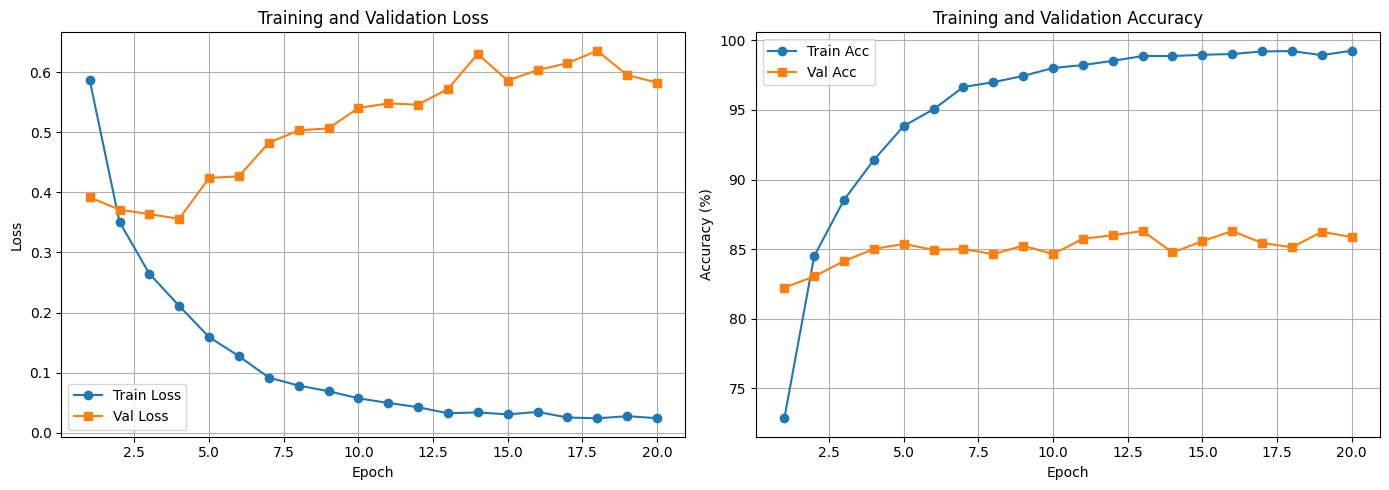

Training history saved to ./checkpoints/training_history.png


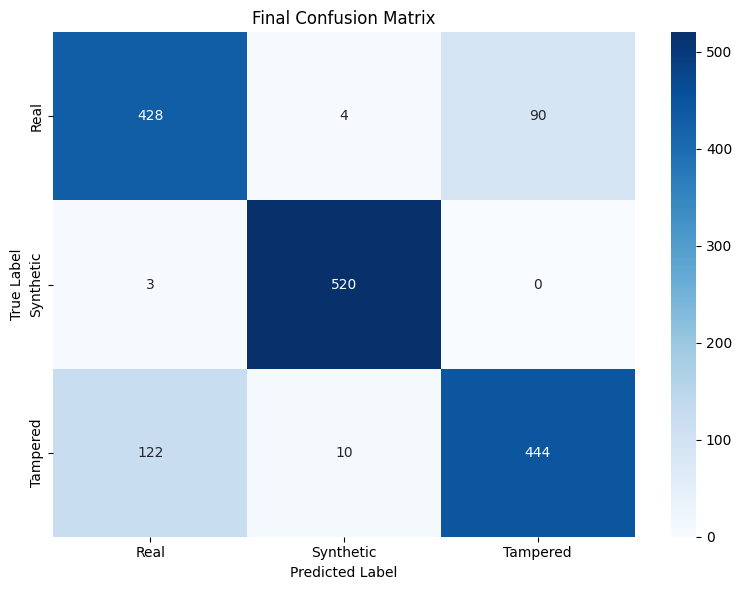

Confusion matrix saved to ./checkpoints/confusion_matrix.png


In [14]:
print("Generating plots...")

# Plot training history
plot_training_history(results, os.path.join(config.save_dir, 'training_history.png'))

# Plot final confusion matrix
plot_confusion_matrix(cm, os.path.join(config.save_dir, 'confusion_matrix.png'))

In [15]:
def evaluate_model_full(model, dataloader, device, class_names=['Real','Synthetic','Tampered'], set_name='Test'):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"{set_name} Evaluation"):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    # Convert to arrays
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.vstack(all_probs)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Overall accuracy
    acc = (all_labels == all_preds).mean() * 100

    # Per-class metrics
    per_class_precision = precision_score(all_labels, all_preds, labels=[0,1,2], average=None)
    per_class_recall = recall_score(all_labels, all_preds, labels=[0,1,2], average=None)
    per_class_f1 = f1_score(all_labels, all_preds, labels=[0,1,2], average=None)

    # Macro metrics
    macro_precision = precision_score(all_labels, all_preds, average='macro')
    macro_recall = recall_score(all_labels, all_preds, average='macro')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    # Weighted metrics
    weighted_precision = precision_score(all_labels, all_preds, average='weighted')
    weighted_recall = recall_score(all_labels, all_preds, average='weighted')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    # AUC
    labels_onehot = np.zeros((all_labels.size, len(class_names)))
    labels_onehot[np.arange(all_labels.size), all_labels] = 1
    auc = roc_auc_score(labels_onehot, all_probs, average='macro')

    # Print metrics
    print(f"\n{'='*60}")
    print(f"{set_name} Metrics")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {acc:.2f}%")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall:    {macro_recall:.4f}")
    print(f"Macro F1:        {macro_f1:.4f}")
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall:    {weighted_recall:.4f}")
    print(f"Weighted F1:        {weighted_f1:.4f}")
    print(f"AUC: {auc:.4f}")

    print("\nPer-Class Metrics:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'{set_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': acc,
        'macro': {'precision': macro_precision, 'recall': macro_recall, 'f1': macro_f1},
        'weighted': {'precision': weighted_precision, 'recall': weighted_recall, 'f1': weighted_f1},
        'per_class': {cls: {'precision': per_class_precision[i], 'recall': per_class_recall[i], 'f1': per_class_f1[i]}
                      for i, cls in enumerate(class_names)},
        'auc': auc,
        'confusion_matrix': cm
    }

Test Evaluation: 100%|██████████| 51/51 [00:54<00:00,  1.07s/it]



Test Metrics
Overall Accuracy: 86.17%
Macro Precision: 0.8631
Macro Recall:    0.8610
Macro F1:        0.8601
Weighted Precision: 0.8634
Weighted Recall:    0.8617
Weighted F1:        0.8606
AUC: 0.9591

Per-Class Metrics:
Real: Precision=0.7700, Recall=0.8540, F1=0.8098
Synthetic: Precision=0.9819, Recall=0.9982, F1=0.9900
Tampered: Precision=0.8373, Recall=0.7308, F1=0.7804


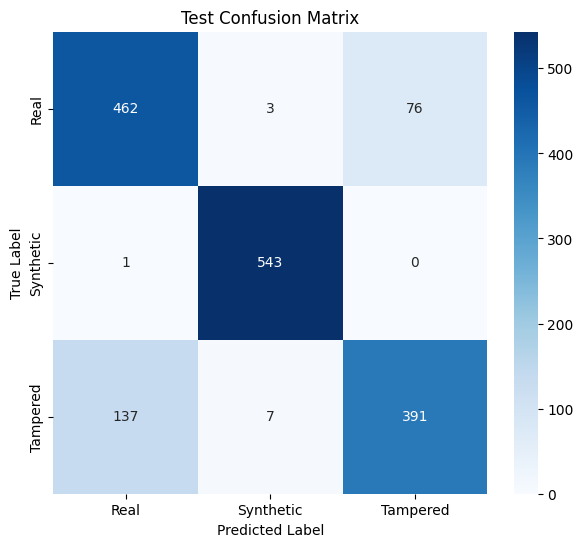

In [16]:
checkpoint = torch.load('./checkpoints/best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

results = evaluate_model_full(model, test_loader, device, set_name='Test')
